# Libaries to import 

In [1]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from error_coding import *
from to_import import *
import ldpcPython as ldpc

# Transmitsion
### Importing data, preparing them into the relevant formats, and saving/playing the output .wav file

In [2]:
# Load data here

# Random bits 
CE_binary = binaryTextFileToBinary('Data_Files/random_bits.txt')

# Original binary file
principia_binary = imageFileToBinary('Data_Files/PRINCIPIA.txt')
conv_binary = imageFileToBinary('Data_Files/circular_conv.bmp')
rickroll_binary  = imageFileToBinary('Data_Files/rickroll.gif')
kokoro_binary  = binaryTextFileToBinary('Data_Files/kokoro_bin.txt')

binary = kokoro_binary

In [3]:
# Add metadata here
data_byte_length = int(len(binary)/8)
file_name = "grp1_challenge_2.gif"

line = file_name+str(data_byte_length)
metadata = '0' + bin(int.from_bytes(line.encode(), 'big'))[2:]
metadata = metadata[:len(file_name)*8] + '00000000' + metadata[len(file_name)*8:] + '00000000'

binary = metadata+binary
print(data_byte_length)
str_to_bytearray(binary)[:100]

398630


bytearray(b'grp1_challenge_2.gif\x00398630\x00Part 1: Sensei and I    I ALWAYS called him "Sensei." [note1] I shall th')

In [4]:
# Error coding here

In [5]:
# Set the parameters for transmission
Mode = "B" # select mode from A, B, C

# Cyclic Prefix
CP_mode = {"A": 224, "B": 704, "C": 1184}

# DFT length 
N = 4096
CP = CP_mode[Mode]

# Number of time indecies we go back in time from the "optimal point"
guard = 20

# Number of known symbol repeats for every frame
CE_repeat = 20

# Number of data symbols in each frame
frame_data_length = 180

In [6]:
# Make your instructions ( THIS CAN BE MADE MORE COMPLICATED USING MAGNITUDE DATA FROM THE CHANNEL TF )
instruction = []
for i in range(int(N/2 - 1)):
    if i <1499 and i >= 99:
        instruction.append(1)
    else: 
        instruction.append(0)
        
# assuming 0 -> no data, 1 -> QPSK, 2 -> 16QAM
# find number of bits necessary for each OFDM symbol 
bits_in_ofdm_symbol = 0
for value in instruction: 
    bits_in_ofdm_symbol += value*2

In [7]:
# XOR operation

# This is information shared to the receiver
rand_binary = CE_binary[:bits_in_ofdm_symbol]  
data_binary_len = len(binary)

# Not shared to receiver
rand_for_xor = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]

# XOR the coded binary sequence
coded_binary = xor(binary, rand_for_xor)

In [8]:
'''# channel to log-likelihood ratios
def ch2llr(ch, sigma2):
    return 2.0/sigma2*ch

# select decoding algorythm
algorythm = 'sumprod'
mycode = ldpc.code()
K = mycode.K
# need binary as array
binary = np.array(list(binary), dtype=int)
# preallocate
codeword = np.zeros(len(binary)*2)
# encode
for i in range(len(binary)//K):
    codeword[i*K*2:(i+1)*K*2] = mycode.encode(binary[i*K:(i+1)*K])
# turn to binary string
binary_codeword = ''.join(str(int(x)) for x in codeword)
print(binary_codeword[:100])'''

"# channel to log-likelihood ratios\ndef ch2llr(ch, sigma2):\n    return 2.0/sigma2*ch\n\n# select decoding algorythm\nalgorythm = 'sumprod'\nmycode = ldpc.code()\nK = mycode.K\n# need binary as array\nbinary = np.array(list(binary), dtype=int)\n# preallocate\ncodeword = np.zeros(len(binary)*2)\n# encode\nfor i in range(len(binary)//K):\n    codeword[i*K*2:(i+1)*K*2] = mycode.encode(binary[i*K:(i+1)*K])\n# turn to binary string\nbinary_codeword = ''.join(str(int(x)) for x in codeword)\nprint(binary_codeword[:100])"

In [9]:
# QAM modulation for the coded binary sequence

# Modulate the random sequence used for channel estimation using QPSK
# the first one uses all bins for known data
# the second one only uses the bins that contain data even for known data 
CE_modulated = qpsk(CE_binary)
#CE_modulated = varyingModulation_std(CE_binary, instruction, N, CE_binary, print_progress = True, max_odfm_symbol =1)

# Modulate the data symbols using the instruction array
data_modulated = varyingModulation_std(coded_binary, instruction, N, CE_binary, print_progress = True)

bitcount 2800
additional  2736
data length  3189264
new data len  3192000
symbol number 100 is done.
symbol number 200 is done.
symbol number 300 is done.
symbol number 400 is done.
symbol number 500 is done.
symbol number 600 is done.
symbol number 700 is done.
symbol number 800 is done.
symbol number 900 is done.
symbol number 1000 is done.
symbol number 1100 is done.


In [10]:
# Chirp signal 
Start_F = 0
End_F = 8000
Time = 5*(CP+N)/fs

# Prepare chirp signal
chirp_signal = Chirp(Start_F,End_F,Time, volume = 100)

In [11]:
# For channel esimation (CE)

# Prepare CE and payload data to be transmitted
CE_symbols, CE_Freq = ofdmSymbols(CE_modulated, CP, N)
Payload_symbols, Payload_Freq = ofdmSymbols(data_modulated, CP, N)

# Adjust the number of OFDM symbols in the payload so it has intger number of frame content
extra = frame_data_length - len(Payload_symbols)%frame_data_length
for i in range(extra):
    Payload_symbols = np.concatenate((Payload_symbols, [CE_symbols[1]]))
    

# Identify number of frames are present in the transmitted sequence
num_of_frames = int(len(Payload_symbols)/frame_data_length)

In [12]:
# Prepare what to actually transmit

# Channel estimation at the beginning
CE_transmit = repeat_signal(CE_symbols[0], CE_repeat)
known_freq = CE_Freq[0]

# Payload mixed with CE symbols distributed between them
Payload = prepare_payload_std(Payload_symbols, CE_transmit, chirp_signal, num_of_frames, frame_data_length)

In [13]:
Tx = (Pause(20),) + tuple(Payload) + (chirp_signal,) # Pause 20 is just to remove any effects a the beginning of the transmission 
Transmit_time = round(len(np.concatenate(Tx))/fs, 2)


print("Transmit signal is", math.floor(Transmit_time/60), "min and", round(Transmit_time%60,3), "seconds")

Transmit signal is 2 min and 58.0 seconds


In [14]:
# Transmit the message / save the wav file
# playOutput = True to play the wave file
x = save_transmit( Tx , playOutput=False)

# Receiver

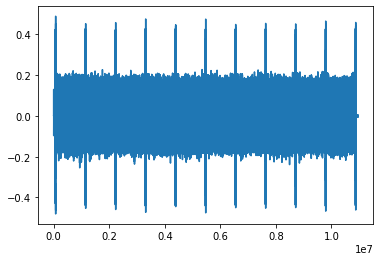

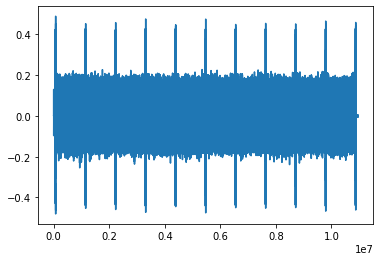

In [15]:
# Import the recorded signal
#y = audioDataFromFile('Wav_Files/challenge2_good_channel1.wav')
y = audioDataFromFile('Wav_Files/other_grp/gr5ch2_signal.wav')


# Find the first chirp and return the signal from just before that chirp
y_signal = detect_chirps(y, chirp_signal, 60)

plot_y(y)
plot_y(y_signal, f =1)

In [16]:
#removeChirpAndPause_std(y_signal, chirp_signal, fs*5, plot = True, rng = 100)

In [17]:
(N + CP) * (frame_data_length + CE_repeat *2) + len(chirp_signal)
( N+CP )* (frame_data_length + CE_repeat *2)+ len(chirp_signal)

1080000

In [18]:
# length of each frame in time steps
length = (N + CP) * (frame_data_length + CE_repeat*2) + len(chirp_signal)
frame_count = count_frames(y_signal, chirp_signal, length)
print("number of frames should be", frame_count)

number of frames should be 10


Completed frame 1
   Linear phase gradient was  0.025541802440377133
Completed frame 2
   Linear phase gradient was  0.025861893704936214
Completed frame 3
   Linear phase gradient was  0.025803141874653383
Completed frame 4
   Linear phase gradient was  0.015376659789240146
Completed frame 5
   Linear phase gradient was  0.009763024930671117
Completed frame 6
   Linear phase gradient was  0.026202556184137523
Completed frame 7
   Linear phase gradient was  -0.0013903310038824058
Completed frame 8
   Linear phase gradient was  0.008505078424847474
Completed frame 9
   Linear phase gradient was  -0.01776854187465336
Data slicing complete


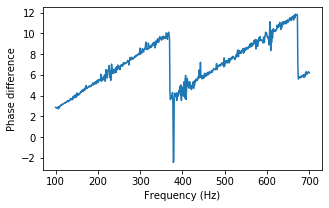

In [32]:
#################################################################################################
# TUNABLE PARAMETERS!
#################################################################################################

stable_phase_start = 100     # where we estimate the "stable region" of the phase to start
stable_phase_length = 600    # how long the stable region continues for
plot = True                 # display plots or not

#################################################################################################


# Calculating time index lengths
data_index_length = frame_data_length * (N+CP)
CE_index_length = CE_repeat * (N+CP)


y_use = y_signal
# big loop to find out everything
for i in range(frame_count):
    
    # obtain only the time series for one frame
    y_data = removeChirpAndPause_std(y_use, chirp_signal, fs*3, plot = False, rng = 100)
    


    # Slice the data to retrieve the CE
    CE_samples, CE_freq, remaining = sliceData(y_data, CP-guard, N, CP, CE_repeat)
    CE_samples_end, CE_freq_end, remaining_end \
                    = sliceData(y_data[data_index_length + CE_index_length:], CP-guard, N, CP, CE_repeat)
    
    
    # Obtain channel response at the beginning and end of the frame
    # channel response -> Impulse response and Frequency response (Transfer function)
    impulse_start, TF_start = getTF_FreqAverage(CE_freq, known_freq, N, CE_repeat)
    impulse_end, TF_end = getTF_FreqAverage(CE_freq_end, known_freq, N, CE_repeat)


    # Unwrapped phase for positive frequencies of the channel response
    angle_start = np.unwrap(np.angle(TF_start[:2048]))
    angle_end = np.unwrap(np.angle(TF_end[:2048]))

    # Difference in phase 
    difference = []
    for p, val in enumerate(angle_end):
        difference.append(round(val - angle_start[p], 3))
        
    # p = x coordinates, q = y coordinates to do linear curve fitting
    p = np.linspace(stable_phase_start,   stable_phase_start + stable_phase_length,   stable_phase_length)
    q = difference[stable_phase_start:   stable_phase_start + stable_phase_length  ]
    
    # output gradient and y-intercept. 
    param = np.polyfit(p,q,1)
    grad = param[0]

    ##############
    ###### if you want to only use K-Means
    #grad = 0.0255
    ##############
    
    # Organise all the data symbols in the frame into chunks of 2047 frequency bins
    # Also perform phase correction using the gradient of the linear phase added due to the frequency mismatch
    sliced_data = sliceDataContent_std(TF_start, TF_end, remaining, CP-guard, N, CP, frame_data_length, grad, CE_repeat)
    if i == 0:
        freq_data = sliced_data
    else:
        freq_data = np.concatenate((freq_data, sliced_data))
    
    
    # Update the time domain signal for the next frame
    y_use = remaining_end
    
    
    print("Completed frame " + str(i+1))
    print("   Linear phase gradient was ", grad)
    
    
    # plotting stuff for debug purposes
    if plot and i == 7:# and i > 5: # and i < 21:  
        
        '''
        plot_y(difference[stable_phase_start:stable_phase_length + stable_phase_start], f = i+100, title = "difference " + str(i+1))
        plot_y(angle_start, f = i, title = "Phase of positive frequencies. Frame " + str(i+1))
        plot_y(angle_end, f= i)
        
        plt.figure(i+1000)
        plt.yscale("log")
        plt.plot(abs(np.array(TF_start))[:2048])
        plt.plot(abs(np.array(TF_end))[:2048])
        plt.title("Log magnitude plot. Frame " + str(i+1))
        plot_y(abs(np.array(TF_start))[:2048], f=i+2000, title = "Linear magnitude plot. Frame " + str(i+1)) 
        '''
    
        fq = np.linspace(stable_phase_start, stable_phase_start + stable_phase_length, stable_phase_length)
        plt.figure(9, figsize = (5,3))
        plt.plot(fq, difference[stable_phase_start:stable_phase_length + stable_phase_start])
        plt.ylabel("Phase difference")
        plt.xlabel("Frequency (Hz)")
        plt.savefig("Data_Files/grp5incorrect.pdf")
        
        
    if i == 8:
        break
print("Data slicing complete")

#### If using K-means to correct QPSK symbols individually

/Users/kaijunge/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


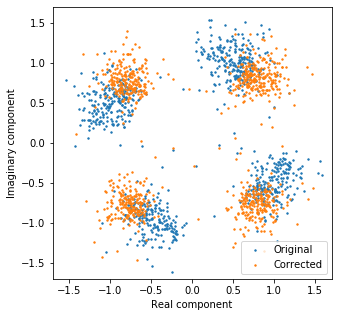

In [27]:
phase = 0
batch = 10
window = 1.7


corrected_freq_data = []
index = 1
strt = 180*0 
duration = 180
oldphase = 0
for i in range(179, 180):#180*index,180*(index+1)): len(freq_data)): #
    
    # if you want to use this method remove the break below this comment!!
    #break
    
    symb = freq_data[i]
    
    plot_res = np.array(symb)[99:998]
    plt.figure(i+2000, figsize = (5,5))
    plt.scatter(plot_res.real, plot_res.imag,s=2, label = "Original")
    #plt.title(i)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)
    
    phase = find_angle_offset(symb[99:998], disp = False)
    
    if i%180 > 5:
        if (phase/oldphase < 1/2 or phase/oldphase > 2) and oldphase != 0:
            phase = oldphase
    oldphase = phase
    
    
    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, phase*j*(1/700))
        
    phase2 = find_angle_offset(symb[99:998])

    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, phase2*j*(1/700))



    corrected_freq_data.append(symb)
    
 
    plot_res = np.array(symb)[99:998]
    plt.scatter(plot_res.real, plot_res.imag,s=2, label = "Corrected")
    #plt.title(i)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)
    
    plt.xlabel("Real component")
    plt.ylabel("Imaginary component")
    plt.legend(loc = "best")
    plt.savefig("Data_Files/grp5_argand.pdf")
    
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase2*j*(1/700))
        
    for j in range(len(symb)):
        symb[j] *= cmath.rect(1, -1*phase*j*(1/700))

    
    if i%180 == 0:
        print(i, "th frame done")

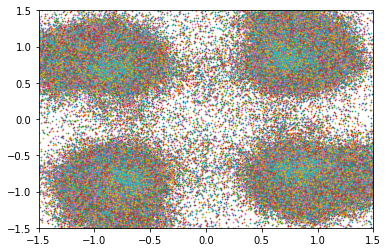

In [89]:
# Plot constellations to see if they are sensible. 


# Set which OFDM symbol to view
start = 180*0
duration = 180*1

# display window size
window = 1.5

for i in range(duration):
    
    plot_res = np.array(corrected_freq_data[start+i])[100:1500]
    plt.scatter(plot_res.real, plot_res.imag, s = 0.5)
    plt.xlim(-1*window,window)
    plt.ylim(-1*window, window)


In [90]:
demodulated_data = demodVaryingModulation_std(np.concatenate(tuple(corrected_freq_data)), instruction, N)


# This is information shared to the receiver
data_binary_len = len(demodulated_data)

# What to xor with the data. rand_binary calculated in Transmission side. 
rand_for_xor_Rx = (rand_binary * math.ceil(data_binary_len/bits_in_ofdm_symbol))[0:data_binary_len]


In [91]:
# XOR the whole sequence
predict = xor(demodulated_data, rand_for_xor_Rx)

In [92]:
str_to_bytearray(predict)#.decode('utf-8', 'replace')

bytearray(b'gr5ch2.wav\x00598380\x00RIFFd!\t\x00WAVGcmt \x90\x81\x00\x00\x01\x00\x01\x00"V\x00\x00"V\x00\x00\x01\x00\x08\x00data\xdc \t\x00ytttwxzzxusrstvxz{{zyyxxxyz{|}~\x7f\x7f\x80\x80\x7f~}||}\x7f\x80\x81\x81\x82\x82\x82\x81\x80~}|~\x80\x82\x83\x82\x80}{zzz|\x7f\x00\x81\x81\x80~||{|}}~\x7f\x7f\x7f\x7f\x7f\x80\x80\x7f~||}\x7f\x80\x81\x82\x82\x82\x83\x83\x84\x83\x82\x81\x81\x83\x86\x88\x89\x88\x86\x83\x81\x81\x81\x83\x85\x87\x88\x88\x88\x86\x84\x83\x82\x82\x83\x83\x84\x84\x84\x85\x84\x84\x85\x85\x85\x83\x81\x80\x7f\x80\x81\x83\x84\x85\x85\x85\x85\x84\x84\x84\x83\x83\x83\x85\x87\x88\x88\x87\x84\x81\x80\x80\x81\x83\x84\x86\x87\x87\x86\x84\x82\x81\x81\x81\x81\x82\x83\x84\x84\x84\x84\x84\x85\x85\x84\x82\x80\x7f\x19\x80\x81\x83\x83\x83\x83\x82\x82\x81\x80~}}~\x80\x81\x81\x81\x7f{xwvwyz{}}}{ywvvwwxyz{{||{ywvvwxy|\x7f\x82\x83\x82\x80~~~~\x7f\x7f\x80\x82\x83\x83\x83\x82\x81\x81\x81\x82\x82\x81\x82\x82\x82\x81\x80\x80\x80\x81\x81\x81\x81\x80\x80\x80\x7f\x7f~|zyxyz{|~~~~|ywwxz|}}~\x7f\x7f\x7f}z

In [93]:
Filename, Length, data_bits = remove_metadata(predict)
print(Filename, Length)

gr5ch2.wav 598380


In [94]:
# If it is NOT text, don't include .decode('utf-8', 'replace')
decoded = str_to_bytearray(data_bits)#.decode('utf-8', 'replace')

In [95]:
decoded

bytearray(b'RIFFd!\t\x00WAVGcmt \x90\x81\x00\x00\x01\x00\x01\x00"V\x00\x00"V\x00\x00\x01\x00\x08\x00data\xdc \t\x00ytttwxzzxusrstvxz{{zyyxxxyz{|}~\x7f\x7f\x80\x80\x7f~}||}\x7f\x80\x81\x81\x82\x82\x82\x81\x80~}|~\x80\x82\x83\x82\x80}{zzz|\x7f\x00\x81\x81\x80~||{|}}~\x7f\x7f\x7f\x7f\x7f\x80\x80\x7f~||}\x7f\x80\x81\x82\x82\x82\x83\x83\x84\x83\x82\x81\x81\x83\x86\x88\x89\x88\x86\x83\x81\x81\x81\x83\x85\x87\x88\x88\x88\x86\x84\x83\x82\x82\x83\x83\x84\x84\x84\x85\x84\x84\x85\x85\x85\x83\x81\x80\x7f\x80\x81\x83\x84\x85\x85\x85\x85\x84\x84\x84\x83\x83\x83\x85\x87\x88\x88\x87\x84\x81\x80\x80\x81\x83\x84\x86\x87\x87\x86\x84\x82\x81\x81\x81\x81\x82\x83\x84\x84\x84\x84\x84\x85\x85\x84\x82\x80\x7f\x19\x80\x81\x83\x83\x83\x83\x82\x82\x81\x80~}}~\x80\x81\x81\x81\x7f{xwvwyz{}}}{ywvvwwxyz{{||{ywvvwxy|\x7f\x82\x83\x82\x80~~~~\x7f\x7f\x80\x82\x83\x83\x83\x82\x81\x81\x81\x82\x82\x81\x82\x82\x82\x81\x80\x80\x80\x81\x81\x81\x81\x80\x80\x80\x7f\x7f~|zyxyz{|~~~~|ywwxz|}}~\x7f\x7f\x7f}zyz{{|}\x7f\x81\x83\x86\x

In [96]:
newFile = open("Data_Files/gr5_2.wav", "wb")
newFile.write(decoded)
newFile.close()

In [28]:
correct = 0
est = data_bits
act = kokoro_binary

max_index = min(len(est), len(act))
for i in range(max_index):
    if est[i] == act[i]:
        correct += 1
        
print(correct/max_index)

1.0
